In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import LineString, Polygon
import plotly.express as px
from shapely.ops import unary_union, linemerge

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# I. Plot MTA Bus Routes
### 1. Load in data. Create df shape_to_route that maps shape_id to bus route name.

In [3]:
# Load the GTFS files
shapes = pd.read_csv('gtfs_m/shapes.txt')
trips = pd.read_csv('gtfs_m/trips.txt')
routes = pd.read_csv('gtfs_m/routes.txt')

# Merge trips with routes to add route_short_name (bus route number)
trips_routes = trips.merge(routes[['route_id', 'route_short_name']], on='route_id', how='left')

# Drop duplicates to get a unique mapping of shape_id to route number
shape_to_route = trips_routes[['shape_id', 'route_short_name']].drop_duplicates()

### 2. Create data frame of bus stops and filter to CRZ

In [5]:
gdf_stops = gpd.GeoDataFrame(shapes, geometry = gpd.points_from_xy(shapes.shape_pt_lon,shapes.shape_pt_lat))

gdf_stops.head(2)

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence  \
0  M010084     40.720696    -73.997726              10001   
1  M010084     40.720812    -73.997659              10002   

                     geometry  
0   POINT (-73.99773 40.7207)  
1  POINT (-73.99766 40.72081)

In [6]:
# Define CRZ
zone_coords = [(-74.02, 40.70), (-73.93, 40.70), (-73.93, 40.768), (-74.02, 40.768)]
zone_polygon = Polygon(zone_coords)

gdf_zone = gpd.GeoDataFrame({'zone': ['Congestion Pricing']}, geometry=[zone_polygon], crs="EPSG:4326")

# Filter bus stops to only those within the CRZ polygon.
# Make sure gdf_stops is in EPSG:4326
gdf_stops_in_zone = gdf_stops[gdf_stops.geometry.within(zone_polygon)]

def create_line_string(group):
    # Ensure the points are sorted by shape_pt_sequence
    coords = group.sort_values('shape_pt_sequence')[['shape_pt_lon', 'shape_pt_lat']].values
    return LineString(coords)

gdf_routes = gdf_stops_in_zone.groupby('shape_id').apply(create_line_string, include_groups=False).reset_index()
gdf_routes.columns = ['shape_id', 'geometry']
gdf_routes = gpd.GeoDataFrame(gdf_routes, geometry='geometry', crs="EPSG:4326")

gdf_routes.head(2)

shape_id                                           geometry
0  M010084  LINESTRING (-73.99773 40.7207, -73.99766 40.72...
1  M010085  LINESTRING (-73.99037 40.73136, -73.99021 40.7...

### 3. Merge with shape_to_route to get bus route names

In [8]:
gdf_routes = gdf_routes.merge(shape_to_route, on = 'shape_id')

# take first route of each route name
route_dict = {}
for index, row in gdf_routes.iterrows():
    if row['route_short_name'] not in route_dict:
        route_dict[row['route_short_name']] = row['geometry']

dedupe = pd.DataFrame({'route_id':route_dict.keys(), 'geometry':route_dict.values()})
# dedupe = dedupe.rename_columns({'route_short_name': 'route_id'})
dedupe = gpd.GeoDataFrame(dedupe, geometry = 'geometry', crs = 'EPSG:4326')


dedupe.head()

route_id                                           geometry
0       M1  LINESTRING (-73.99773 40.7207, -73.99766 40.72...
1       M2  LINESTRING (-73.99037 40.73136, -73.99021 40.7...
2       M3  LINESTRING (-73.99037 40.73136, -73.99021 40.7...
3       M4  LINESTRING (-73.97073 40.76738, -73.97119 40.7...
4       M5  LINESTRING (-73.98903 40.74808, -73.98872 40.7...

### 4. Plot bus routes in CRZ

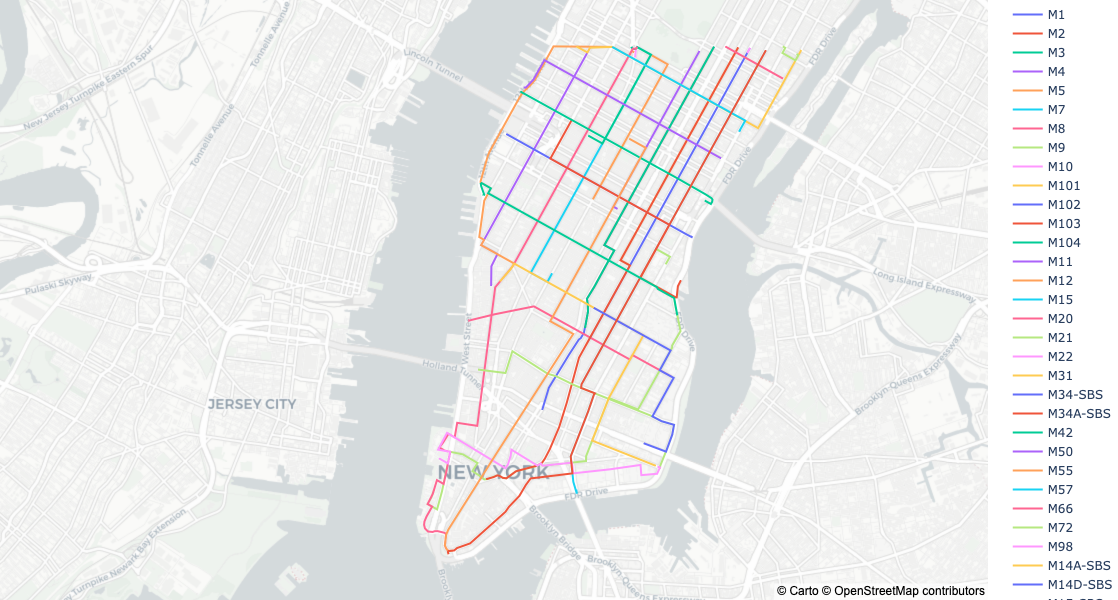

In [10]:
# Ensure your GeoDataFrame is in EPSG:4326
dedupe = dedupe.to_crs(epsg=4326)

# Create a Plotly figure
fig = go.Figure()

# Loop over each route to extract and plot its coordinates
for idx, row in dedupe.iterrows():
    # Check if the geometry is a MultiLineString or a LineString
    if row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry']:
            x, y = line.xy
            fig.add_trace(go.Scattermapbox(
                mode="lines",
                lon=list(x),
                lat=list(y),
                name=str(row['route_id']),
                line=dict(width=2)
            ))
    else:  # LineString
        x, y = row['geometry'].xy
        fig.add_trace(go.Scattermapbox(
            mode="lines",
            lon=list(x),
            lat=list(y),
            name=str(row['route_id']),
            line=dict(width=2)
        ))

# Configure the layout of the map
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=12,
    mapbox_center={"lat": 40.735, "lon": -74.0060},  # Centered on NYC
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    height = 600, width = 800
)

fig.show()

# II. Did speeds improve in areas with bus lanes?

### 1. Bring in bus speed data
* Filter to January data to compare YoY
* Filter to Peak
* Filter to Weekday (day_type = 1)

In [12]:
# mta bus speeds data
bus_speeds = pd.read_csv('https://data.ny.gov/resource/6ksi-7cxr.csv?$limit=10000&borough=Manhattan')
bus_speeds_2025 = pd.read_csv('https://data.ny.gov/resource/4u4b-jge6.csv?$limit=10000&borough=Manhattan')

bus_speeds = pd.concat([bus_speeds, bus_speeds_2025])
bus_speeds['month'] = pd.to_datetime(bus_speeds.month)

bus_speeds['year'] = bus_speeds.month.apply(lambda x:x.year)
bus_speeds['month_code'] = bus_speeds.month.apply(lambda x:x.month)

bus_speeds.head(2)

month    borough  day_type trip_type route_id    period  total_mileage  \
0 2020-01-01  Manhattan         1   LCL/LTD       M1  Off-Peak     56512652.4   
1 2020-01-01  Manhattan         1   LCL/LTD       M1      Peak     32086461.6   

   total_operating_time  average_speed  year  month_code  
0               9445010           5.98  2020           1  
1               5396283           5.95  2020           1

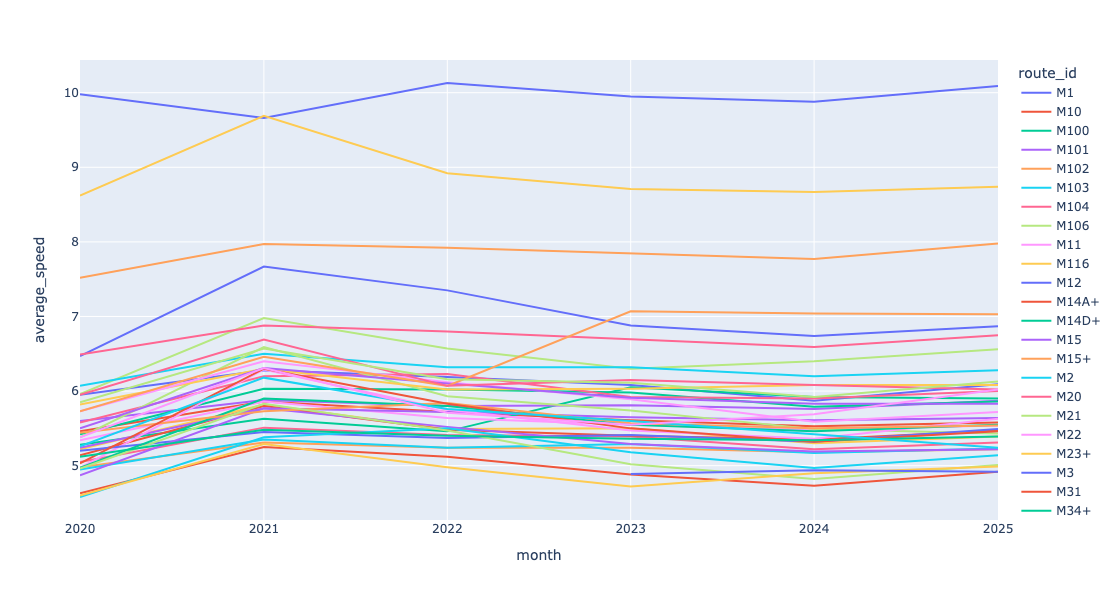

In [13]:
plot = bus_speeds.loc[(bus_speeds.period == 'Peak') &
                      (bus_speeds.day_type == 1) &
                      (bus_speeds.month_code == 1)]

# exploratory line plot to see average speeds for each route in January YoY
fig = px.line(plot, x = 'month', y = 'average_speed', color = 'route_id')
fig.update_layout(height = 600, width = 800)

fig.show()

In [14]:
plot.head()

month    borough  day_type trip_type route_id period  total_mileage  \
1  2020-01-01  Manhattan         1   LCL/LTD       M1   Peak     32086461.6   
5  2020-01-01  Manhattan         1   LCL/LTD      M10   Peak     16009628.4   
9  2020-01-01  Manhattan         1   LCL/LTD     M100   Peak     24065186.4   
13 2020-01-01  Manhattan         1   LCL/LTD     M101   Peak     39757881.6   
17 2020-01-01  Manhattan         1   LCL/LTD     M102   Peak     22343940.0   

    total_operating_time  average_speed  year  month_code  
1                5396283           5.95  2020           1  
5                2929943           5.46  2020           1  
9                4559116           5.28  2020           1  
13               7105686           5.60  2020           1  
17               4485961           4.98  2020           1

In [21]:
# Compare 2024 to 2025 speeds
improve = {}
for route in plot.route_id.unique():
    slice_df = plot.loc[plot.route_id == route]
    speeds = dict(zip(slice_df.year, slice_df.average_speed))
    if speeds[2025] > speeds[2024]:
        improve[route] = 'Improved'
    else:
        improve[route] = 'No Improvement'

# Don't need speed specifics for the map
map_plot = plot[['route_id']].drop_duplicates()
map_plot['performance'] = map_plot['route_id'].map(improve)
map_plot = map_plot.merge(dedupe, on = 'route_id')

map_plot.head(2)

route_id performance                                           geometry
0       M1    Improved  LINESTRING (-73.99773 40.7207, -73.99766 40.72...
1      M10    Improved  LINESTRING (-73.98243 40.76793, -73.9824 40.76...

### 2. Plot bus lanes.

In [24]:
bus_lanes = pd.read_csv('https://data.cityofnewyork.us/api/views/ycrg-ses3/rows.csv?')
bus_lanes['geometry'] = gpd.GeoSeries.from_wkt(bus_lanes['the_geom'])
bus_lanes = gpd.GeoDataFrame(bus_lanes, geometry = 'geometry', crs = 'EPSG:4326')
bus_lanes = bus_lanes[bus_lanes.geometry.within(zone_polygon)].reset_index(drop=True)

bus_lanes.head(2)

the_geom       Street TrafDir  \
0  MULTILINESTRING ((-74.00306956973111 40.706142...  F D R DRIVE       A   
1  MULTILINESTRING ((-74.00303118722634 40.706165...  F D R DRIVE       A   

   SegmentID  RW_TYPE  StreetWidt Boro     Facility    Hours           Days  \
0     240351      2.0          32  MAN  FDR Dr (WB)  2pm-8pm  Monday-Friday   
1     240352      2.0          32  MAN  FDR Dr (WB)  2pm-8pm  Monday-Friday   

  Lane_width  Year1  Year2  Year3            Lane_Type1 Lane_Type2 SBS_Route1  \
0     Single   2019      0      0  Bus lane on shoulder        NaN        NaN   
1     Single   2019      0      0  Bus lane on shoulder        NaN        NaN   

  SBS_Route2  SBS_Route3  Days_Code  Last_Updat Lane_Color  Open_dates  \
0        NaN         NaN          5  12/19/2019        NaN  12/19/2019   
1        NaN         NaN          5  12/19/2019        NaN  12/19/2019   

  Chron_ID_1  Shape_Leng                                         Shape_Le_1  \
0    MAN2019   13.492314  MULTILINESTRING ((983398.9455878437 196543.360...   
1    MAN2019  249.023039  MULTILINESTRING ((983409.5876269192 196551.654...   

                                            geometry  
0  MULTILINESTRING ((-74.00307 40.70614, -74.0030...  
1  MULTILINESTRING ((-74.00303 40.70617, -74.0030...

In [26]:
# Create one trace of the bus_lanes
combined = unary_union(bus_lanes.geometry)
merged = linemerge(combined)

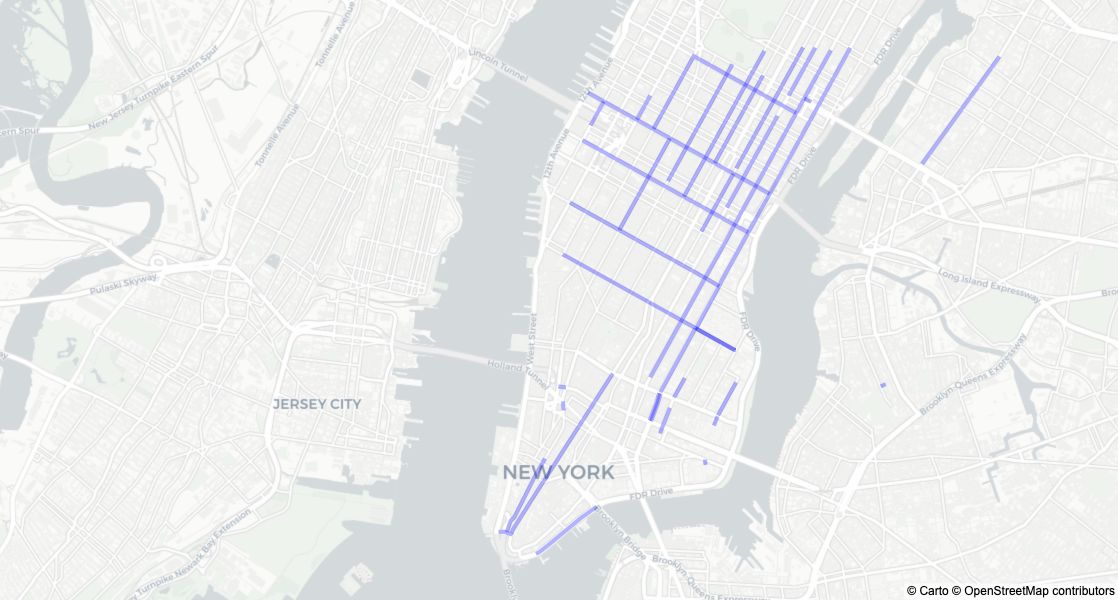

In [28]:
# Plot Bus Lanes Only
fig = go.Figure()

lons, lats = [], []
for line in merged.geoms:  # Each piece is a LineString
    x, y = line.xy
    lons.extend(x)
    lats.extend(y)
    # Add None to separate segments in a single trace
    lons.append(None)
    lats.append(None)

fig.add_trace(go.Scattermapbox(
    mode='lines',
    lon=lons,
    lat=lats,
    name='Combined Bus Lanes',
    line=dict(width=4, color='blue'),
    opacity = 0.3
))


fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=12,
    mapbox_center={"lat": 40.735, "lon": -74.0060},
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    height=600,
    width=800,
)

fig.show()


### 3. Plot speed improvement on top of bus lanes

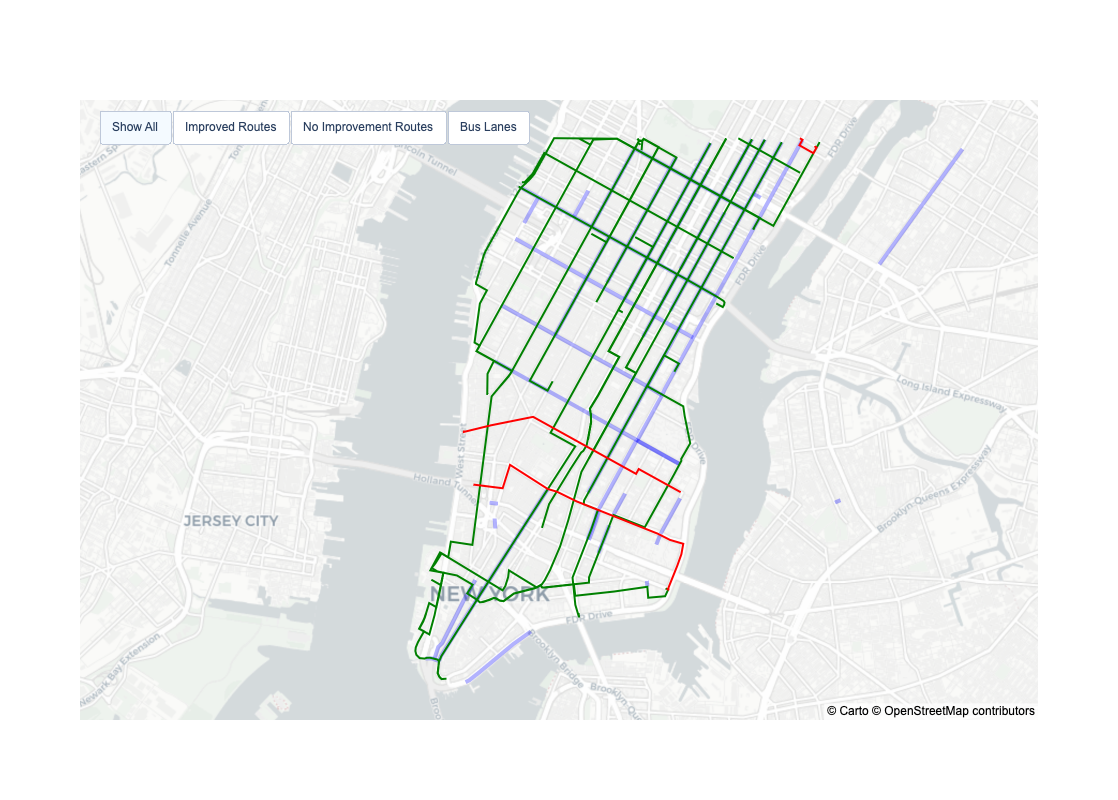

In [32]:
'''
TO-DO: Update hover data. Remove coordinates, add in speed improvement.
'''

fig = go.Figure()

lons, lats = [], []
for line in merged.geoms:  # Each piece is a LineString
    x, y = line.xy
    lons.extend(x)
    lats.extend(y)
    # Add None to separate segments in a single trace
    lons.append(None)
    lats.append(None)

fig.add_trace(go.Scattermapbox(
    mode='lines',
    lon=lons,
    lat=lats,
    name='Bus Lanes',
    line=dict(width=4, color='blue'),
    opacity = 0.3
))

improved = map_plot[map_plot['performance'] == 'Improved']
for idx, row in improved.iterrows():
    x, y = row['geometry'].xy
    fig.add_trace(go.Scattermapbox(
        mode="lines",
        lon=list(x),
        lat=list(y),
        name=str(row['route_id']),
        line=dict(width=2, color = 'green')
    ))

no_improvement = map_plot[map_plot['performance'] == 'No Improvement']
for idx, row in no_improvement.iterrows():
    x, y = row['geometry'].xy
    fig.add_trace(go.Scattermapbox(
        mode="lines",
        lon=list(x),
        lat=list(y),
        name=str(row['route_id']),
        line=dict(width=2, color = 'red')
    ))

# Number of traces in each group
improved_count = len(improved)
not_improved_count = len(no_improvement)

# Update menus for filtering
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            direction='left',
            buttons=[
                dict(
                    label='Show All',
                    method='update',
                    args=[
                        {'visible': [True] * len(fig.data)}
                    ]
                ),
                dict(
                    label='Improved Routes',
                    method='update',
                    args=[
                        {'visible': [True] + [True]*improved_count + [False] * not_improved_count}
                    ]
                ),
                dict(
                    label='No Improvement Routes',
                    method='update',
                    args=[
                        {'visible': [True] + [False]*improved_count + [True] * not_improved_count}
                    ]
                ),
                dict(
                    label='Bus Lanes',
                    method='update',
                    args=[
                        {'visible': [True] + [False]*(improved_count + not_improved_count)}
                    ]
                )
            ],
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.02,
            xanchor="left",
            y=1,
            yanchor="top"
        )
    ],
    mapbox_style="carto-positron",
    mapbox_zoom=12.1,
    mapbox_center={"lat": 40.735, "lon": -73.995},
    showlegend=False,
    height = 800, width = 800,
    yaxis_range = [4, 12],
    font_family = 'Arial'
)

fig.show()